In [43]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

T = 15
batch_size = 64
A = 64
B = 64
z_size = 10
read_size = 5
write_size = 5
enc_size = 256
dec_size = 256
epoch_num = 20
learning_rate = 1e-3
beta1 = 0.5
USE_CUDA = True
clip = 5.0
attention=1


def Variable(data, *args, **kwargs):
    if USE_CUDA:
        data = data.cuda()
    return autograd.Variable(data,*args, **kwargs)


def xrecons_grid(X,B,A):
	"""
	plots canvas for single time step
	X is x_recons, (batch_size x img_size)
	assumes features = BxA images
	batch is assumed to be a square number
	"""
	padsize=1
	padval=.5
	ph=B+2*padsize
	pw=A+2*padsize
	batch_size=X.shape[0]
	N=int(np.sqrt(batch_size))
	X=X.reshape((N,N,B,A))
	img=np.ones((N*ph,N*pw))*padval
	for i in range(N):
		for j in range(N):
			startr=i*ph+padsize
			endr=startr+B
			startc=j*pw+padsize
			endc=startc+A
			img[startr:endr,startc:endc]=X[i,j,:,:]
	return img

def save_image(x,count=0):
    for t in range(T):
        img = xrecons_grid(x[t],B,A)
        plt.matshow(img, cmap=plt.cm.gray)
        imgname = '/Users/ivy2021/Documents/DRAW/gen_image_multi/count_%d_%s_%d.png' % (count,'test', t)  # you can merge using imagemagick, i.e. convert -delay 10 -loop 0 *.png mnist.gif
        plt.savefig(imgname)
        print(imgname)



class DrawModel(nn.Module):
    def __init__(self,T,A,B,z_size,read_size,write_size,dec_size,enc_size,attention):
        super(DrawModel,self).__init__()
        self.T = T
        # self.batch_size = batch_size
        self.attention = attention
        self.A = A
        self.B = B
        self.z_size = z_size
        self.read_size = read_size
        self.write_size = write_size
        self.dec_size = dec_size
        self.enc_size = enc_size
        self.cs = [0] * T #canvas
        self.logsigmas,self.sigmas,self.mus = [0] * T,[0] * T,[0] * T

        self.encoder = nn.LSTMCell(2 * B * A + dec_size, enc_size)   #encoder for read without attention
        self.encoder_a = nn.LSTMCell(2 * read_size * read_size + dec_size, enc_size) #encoder for read with attention
        self.decoder = nn.LSTMCell(z_size, dec_size)                 #decoder

        self.mu_linear = nn.Linear(dec_size, z_size)    #linear for eq(1) for latent distribution
        self.sigma_linear = nn.Linear(dec_size, z_size) #linear for eq(2) for latent distribution
        self.dec_linear = nn.Linear(dec_size, 5)        #linear for eq(21) generating 5 params from h_dec
        
        self.dec_w_linear_a = nn.Linear(dec_size, write_size*write_size)     #linear for eq(28)
        self.dec_w_linear = nn.Linear(dec_size, A*B)                         #linear for eq(18)

        self.sigmoid = nn.Sigmoid()


    def forward(self,x):
        self.batch_size = x.size()[0]
        h_enc_prev = Variable(torch.zeros(self.batch_size, self.enc_size))
        h_dec_prev = Variable(torch.zeros(self.batch_size, self.dec_size))

        enc_state = Variable(torch.zeros(self.batch_size,self.enc_size))
        dec_state = Variable(torch.zeros(self.batch_size, self.dec_size))

        if (self.attention):
          for t in range(self.T):
              c_prev = Variable(torch.zeros(self.batch_size,self.A * self.B)) if t == 0 else self.cs[t-1]
              x_hat = x - self.sigmoid(c_prev)       #eq(3)
              r_t = self.read(x,x_hat,h_dec_prev,1)  #eq(4)
              h_enc, enc_state = self.encoder_a(torch.cat((r_t,h_dec_prev),1),(h_enc_prev,enc_state)) #eq(5)
              h_enc_prev = h_enc
              z, self.mus[t], self.logsigmas[t], self.sigmas[t] = self.sampleQ(h_enc) #eq(6)
              h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
              self.cs[t] = c_prev + self.write(h_dec,1)
              h_dec_prev = h_dec
        else:
          for t in range(self.T):
              c_prev = Variable(torch.zeros(self.batch_size,self.A * self.B)) if t == 0 else self.cs[t-1]
              x_hat = x - self.sigmoid(c_prev)     #eq(3)
              r_t = self.read(x,x_hat,h_dec_prev,0) #eq(4)
              h_enc, enc_state = self.encoder(torch.cat((r_t,h_dec_prev),1),(h_enc_prev,enc_state)) #eq(5)
              h_enc_prev = h_enc
              z, self.mus[t], self.logsigmas[t], self.sigmas[t] = self.sampleQ(h_enc) #eq(6)
              h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
              self.cs[t] = c_prev + self.write(h_dec,0)
              h_dec_prev = h_dec


    def loss(self,x):
        self.forward(x)
        criterion = nn.BCELoss()
        x_recons = self.sigmoid(self.cs[-1])
        Lx = criterion(x_recons,x) * self.A * self.B
        Lz = 0
        kl_terms = [0] * T
        for t in range(self.T):
            mu_2 = self.mus[t] * self.mus[t]
            sigma_2 = self.sigmas[t] * self.sigmas[t]
            logsigma = self.logsigmas[t]
            # Lz += (0.5 * (mu_2 + sigma_2 - 2 * logsigma))    #eq(11)
            kl_terms[t] = 0.5 * torch.sum(mu_2+sigma_2-2 * logsigma,1) - self.T * 0.5
            Lz += kl_terms[t]
        # Lz -= self.T / 2
        Lz = torch.mean(Lz)    
        loss = Lz + Lx    #eq(12)
        return loss


    def gaussian_filter(self,h_dec,N):
        params = self.dec_linear(h_dec) #eq(21)
        gx, gy, log_sigma2, log_delta, log_gamma = torch.split(params, 1, dim=1) #each param has size batch_sizex1
        gx = (self.A+1)/2 * (gx+1) #eq(22)
        gy = (self.B+1)/2 * (gy+1) #eq(23)
        delta = (max(self.A,self.B) - 1) / (N - 1) * torch.exp(log_delta)  #eq(24)
        sigma2 = torch.exp(log_sigma2) 
        gamma = torch.exp(log_gamma)
        
        #make mean_x, mean_y, a, b into tensors with shape (1, N, AorB) to make Fx and Fy with the same shape
        mean_x = torch.zeros((delta.size()[0],A)).to('cuda:0') #use this trick because I cannot make empty tensor 
        mean_y = torch.zeros((delta.size()[0],B)).to('cuda:0') #use this trick because I cannot make empty tensor
        for i in range (5):
          mean_x_i = torch.ones(A).to('cuda:0') * (gx + (i- N/2 -0.5)*delta)  #eq(19) 
          mean_x = torch.cat([mean_x, mean_x_i], axis=-1)
          mean_y_j = torch.ones(B).to('cuda:0') * (gy + (i- N/2 -0.5)*delta)  #eq(20) 
          mean_y = torch.cat([mean_y,mean_y_j], axis =-1)
        mean_x = mean_x[:,A:]     #undo the torch.zeros trick
        mean_y = mean_y[:,B:]     #undo the torch.zeros trick
        mean_x = mean_x.view(-1, N, A) #each row consists of A elements of mean_x(i)
        mean_y = mean_y.view(-1, N, B) #each row consists of B elements of mean_y(j)
        a = torch.zeros((delta.size()[0],A)).to('cuda:0')
        b = torch.zeros((delta.size()[0],B)).to('cuda:0')
        for i in range (N):
          ai = torch.ones((delta.size()[0],A)).to('cuda:0') * torch.range(0,A-1).to('cuda:0')
          bj = torch.ones((delta.size()[0],B)).to('cuda:0') * torch.range(0,B-1).to('cuda:0')
          a = torch.cat([a,ai], axis=-1)
          b = torch.cat([b,bj], axis=-1)
        a = a[:,A:]
        b = b[:,B:]
        a = a.view(-1, N, A)
        b = b.view(-1, N, B)

        sig = torch.ones(A).to('cuda:0') * sigma2
        sigma_2 = sig
        for i in range(N-1):
          sigma_2 = torch.cat([sigma_2,sig], axis=1)
        sigma_2 = sigma_2.view(-1,N,A)
        #print(a.size(),mean_x.size(),sigma_2.size())
        Fx = torch.exp(-torch.square(a-mean_x)/(2*sigma_2))  #eq(25)
        Fy = torch.exp(-torch.square(b-mean_y)/(2*sigma_2))  #eq(26)
        #normalize each row of Fx and Fy to sum 1
        Fx=Fx/(torch.sum(Fx,2,keepdim=True)+1e-8)
        Fy=Fy/(torch.sum(Fy,2,keepdim=True)+1e-8)
        

        return Fx,Fy,gamma

    def read(self,x,x_hat,h_dec_prev, attention):
        if (attention):
          Fx,Fy,gamma = self.gaussian_filter(h_dec_prev, self.read_size)
          #transpose Fx per batch
          Fxt = Fx.transpose(2,1)
          #reshape x from (batch,B*A) to (batch,B,A)
          x_matrix = x.view(-1,B,A)
          xhat_matrix = x_hat.view(-1,B,A)
          #concat
          first_half = torch.bmm(torch.bmm(Fy,x_matrix),Fxt)
          first_half = first_half.view(-1,self.read_size*self.read_size)
          second_half = torch.bmm(torch.bmm(Fy,xhat_matrix),Fxt)
          second_half = first_half.view(-1,self.read_size*self.read_size)
          gamma = gamma.view(-1,1)
          return gamma*(torch.cat([first_half,second_half], axis=1)) #eq(27)
        else:
          return torch.cat([x,x_hat], 1)  #eq(17)
            
    def write(self,h_dec, attention):
        if (attention):
          w = self.dec_w_linear_a(h_dec) #eq(28)
          w = w.view(self.batch_size,self.write_size,self.write_size)
          Fx,Fy,gamma = self.gaussian_filter(h_dec,write_size)
          Fyt = Fy.transpose(2,1)
          wr =  torch.bmm(torch.bmm(Fyt,w),Fx)      #eq(29)
          wr = wr.view(self.batch_size,self.A*self.B)
          return wr / gamma.view(-1,1)
        else:
          return self.dec_w_linear(h_dec) #eq(18)

    def sampleQ(self,h_enc):
        noise = Variable(torch.randn(self.batch_size, self.z_size))
        mu = self.mu_linear(h_enc)           #eq(1)
        log_sigma = self.sigma_linear(h_enc) #eq(2)
        sigma = torch.exp(log_sigma)

        return mu + sigma * noise , mu , log_sigma, sigma

    def generate(self,batch_size=64):
        self.batch_size = batch_size
        h_dec_prev = Variable(torch.zeros(self.batch_size,self.dec_size),volatile = True)
        dec_state = Variable(torch.zeros(self.batch_size, self.dec_size),volatile = True)

        for t in range(self.T):
            c_prev = Variable(torch.zeros(self.batch_size, self.A * self.B)) if t == 0 else self.cs[t - 1] 
            z = Variable(torch.randn(self.batch_size, self.z_size))      #eq(13)
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))  #eq(14)
            self.cs[t] = c_prev + self.write(h_dec, self.attention)      #eq(15)
            h_dec_prev = h_dec
        imgs = []
        for img in self.cs:
            imgs.append(self.sigmoid(img).cpu().data.numpy())
        return imgs

# Datasets

In [9]:
import torch.optim as optim
from torchvision import datasets,transforms
import torch.utils
import torch.nn.utils
import matplotlib.pyplot as plt


torch.set_default_tensor_type('torch.FloatTensor')

'''
#MNIST
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=batch_size, shuffle=False)

'''


"\n#MNIST\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('data/', train=True, download=True,\n                   transform=transforms.Compose([\n                       transforms.ToTensor()])),\n    batch_size=batch_size, shuffle=False)\n\n"

In [40]:
#DoubleMNIST
import os
from PIL import Image

'''
x_train =[]

listing = os.listdir('/Users/ivy2021/Downloads/double_mnist_seed_123_image_size_64_64/train')
for dir in listing:
    images = os.listdir('/Users/ivy2021/Downloads/double_mnist_seed_123_image_size_64_64/train/'+dir)
    for image in images:
        image = Image.open('/Users/ivy2021/Downloads/double_mnist_seed_123_image_size_64_64/train/'+dir+'/'+image)
        data = np.asarray(image)
        x_train.append(data)
        image.close()

x_train_ = np.reshape(x_train, (-1,64,64))
print(x_train_.shape)
np.save('DoubleMNIST.npy', x_train_)
'''
#output tensor received by pytorch DataLoader are uint8 between 0 and 255.
#x_train_ is still in float64 between 0-1, convert to above.
x_train_ = np.load('DoubleMNIST.npy')
#x_train_ = x_train_.reshape(-1,4096)
data = x_train_.astype(np.float64)
data = 255 * data
images = data.astype(np.uint8)
'''
random_image = np.random.randint(0, len(images))
plt.imshow(images[random_image])
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()
'''

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

transform = None
#transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
dataset = MyDataset(images, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(dataset, batch_size=64, shuffle=True )

# Train

<ipython-input-43-a5d478b16761>:172: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ai = torch.ones((delta.size()[0],A)).to('cuda:0') * torch.range(0,A-1).to('cuda:0')
<ipython-input-43-a5d478b16761>:173: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  bj = torch.ones((delta.size()[0],B)).to('cuda:0') * torch.range(0,B-1).to('cuda:0')
<ipython-input-45-4e4eeeb88bfd>:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)


Epoch-0; Count-100; loss: 636.9222912597656;
Epoch-0; Count-200; loss: 361.47923065185546;
Epoch-0; Count-300; loss: 356.5388882446289;
Epoch-0; Count-400; loss: 377.93644775390624;
Epoch-0; Count-500; loss: 365.46954040527345;
Epoch-0; Count-600; loss: 359.17586517333984;
Epoch-0; Count-700; loss: 351.8438250732422;
Epoch-0; Count-800; loss: 351.0203866577148;
Epoch-0; Count-900; loss: 351.1277362060547;
Epoch-0; Count-1000; loss: 345.6221926879883;
Epoch-1; Count-1100; loss: 349.29782318115235;
Epoch-1; Count-1200; loss: 349.251708984375;
Epoch-1; Count-1300; loss: 358.2622866821289;
Epoch-1; Count-1400; loss: 345.4548864746094;
Epoch-1; Count-1500; loss: 357.17140808105466;
Epoch-1; Count-1600; loss: 361.71110595703124;
Epoch-1; Count-1700; loss: 361.25961151123045;
Epoch-1; Count-1800; loss: 358.97449768066406;
Epoch-1; Count-1900; loss: 353.76857330322264;
Epoch-1; Count-2000; loss: 356.9469967651367;
Epoch-2; Count-2100; loss: 356.20530181884766;
Epoch-2; Count-2200; loss: 355.23

<ipython-input-43-a5d478b16761>:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return autograd.Variable(data,*args, **kwargs)


/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_0.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_1.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_2.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_3.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_4.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_5.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_6.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_7.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_8.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_9.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_10.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_11.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_12.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_3000_test_13.png
/Users/ivy2021/Documents/DRAW/gen_image_mult

<ipython-input-43-a5d478b16761>:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(img, cmap=plt.cm.gray)


/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_4.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_5.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_6.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_7.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_8.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_9.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_10.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_11.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_12.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_13.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_6000_test_14.png
Epoch-6; Count-6100; loss: 270.0833172607422;
Epoch-6; Count-6200; loss: 273.04647674560545;
Epoch-6; Count-6300; loss: 273.41148818969725;
Epoch-6; Count-6400; loss: 271.57872589111327;
Epoch-6; Count-6500; loss: 271.6357760620117;
Epoch-6; Count

Epoch-15; Count-15300; loss: 258.4432302856445;
Epoch-15; Count-15400; loss: 259.64857360839846;
Epoch-15; Count-15500; loss: 264.5846076965332;
Epoch-15; Count-15600; loss: 262.8287306213379;
Epoch-15; Count-15700; loss: 259.48541732788084;
Epoch-15; Count-15800; loss: 262.0514207458496;
Epoch-15; Count-15900; loss: 256.2984764099121;
Epoch-15; Count-16000; loss: 258.757742767334;
Epoch-16; Count-16100; loss: 259.4350286865234;
Epoch-16; Count-16200; loss: 258.38414093017576;
Epoch-16; Count-16300; loss: 259.60029342651364;
Epoch-16; Count-16400; loss: 260.55831817626955;
Epoch-16; Count-16500; loss: 257.9204811096191;
Epoch-16; Count-16600; loss: 262.99546997070314;
Epoch-16; Count-16700; loss: 259.95860473632814;
Epoch-16; Count-16800; loss: 256.2948637390137;
Epoch-16; Count-16900; loss: 257.79622833251955;
Epoch-16; Count-17000; loss: 258.301007232666;
Epoch-17; Count-17100; loss: 255.06186614990236;
Epoch-17; Count-17200; loss: 256.5193424987793;
Epoch-17; Count-17300; loss: 258.

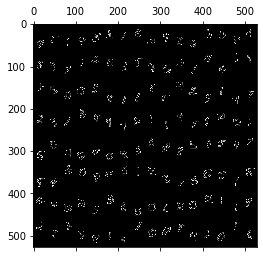

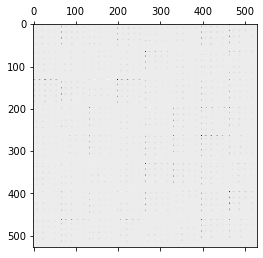

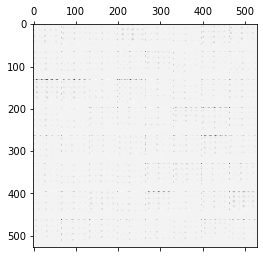

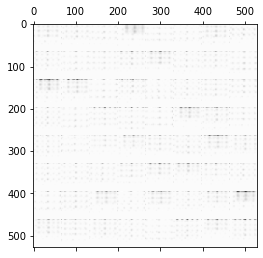

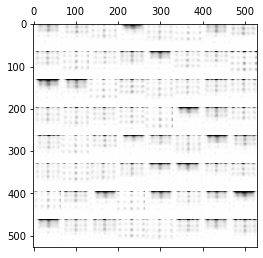

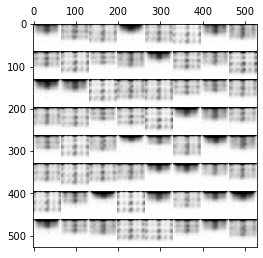

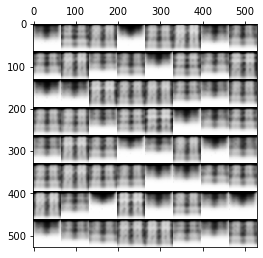

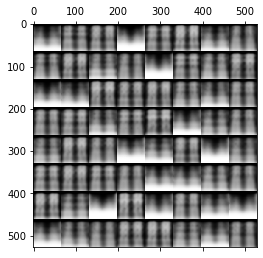

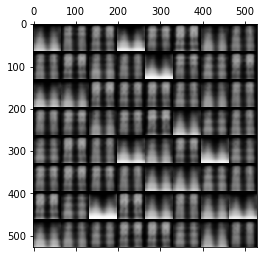

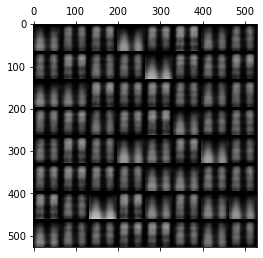

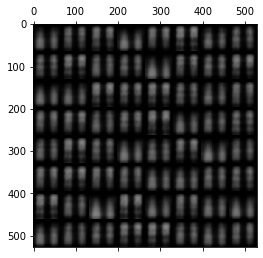

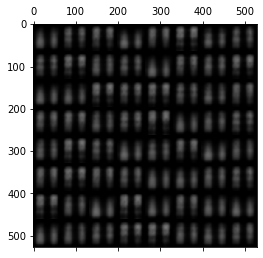

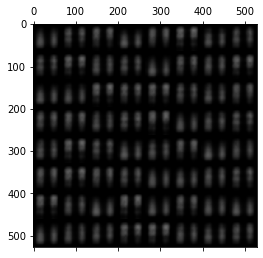

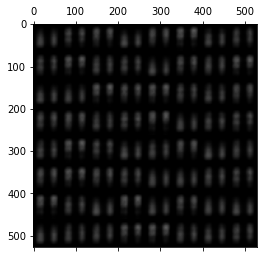

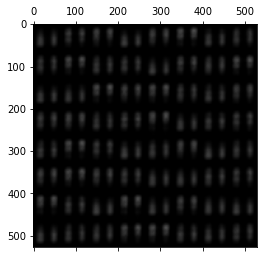

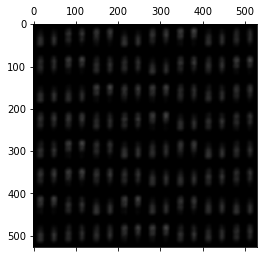

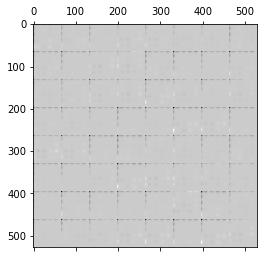

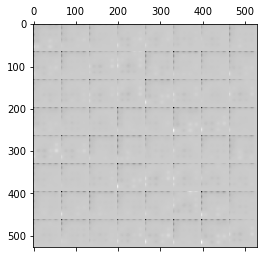

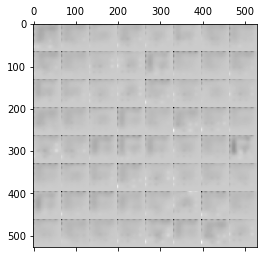

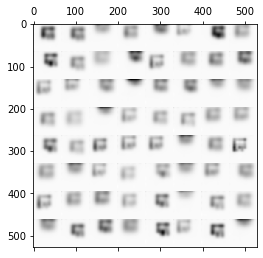

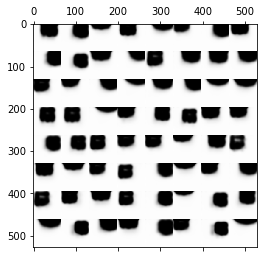

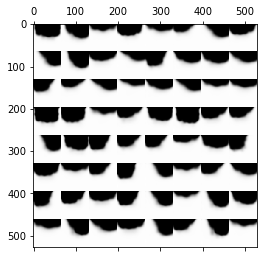

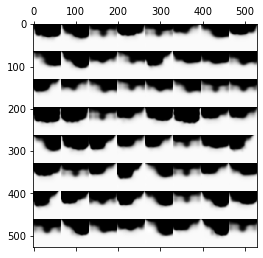

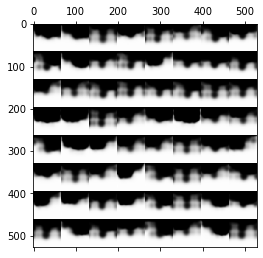

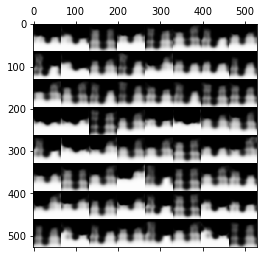

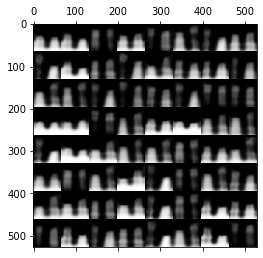

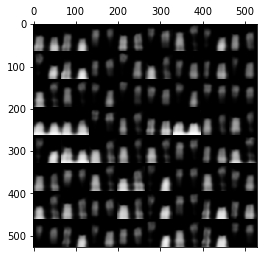

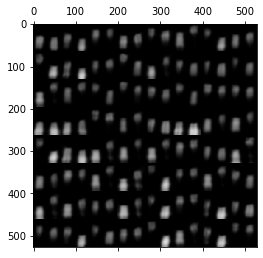

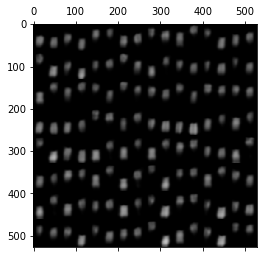

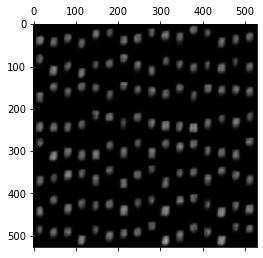

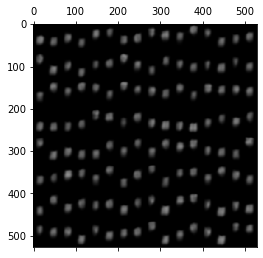

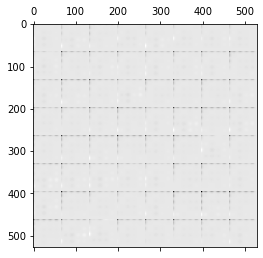

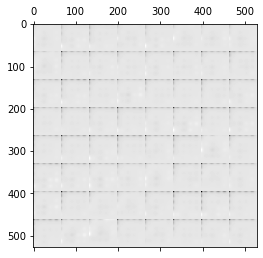

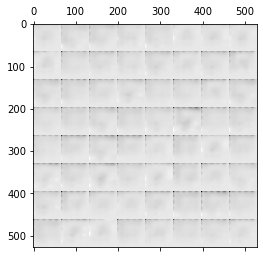

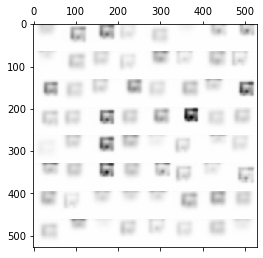

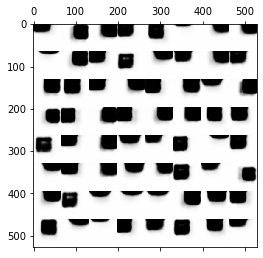

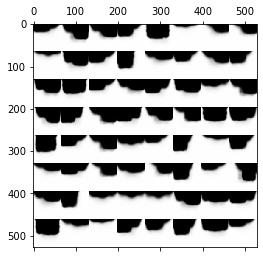

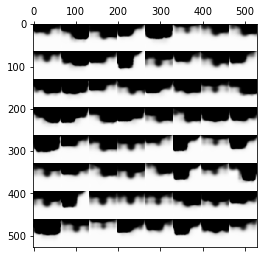

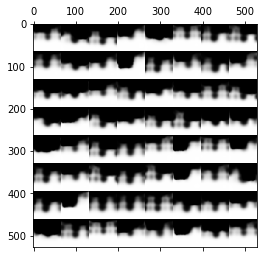

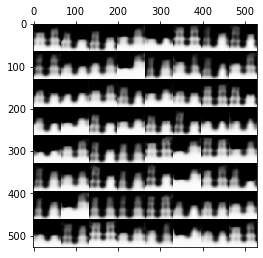

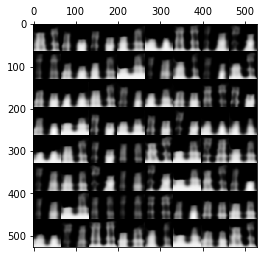

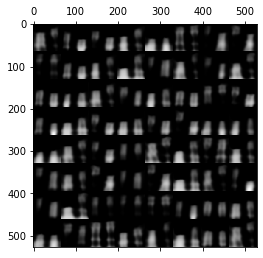

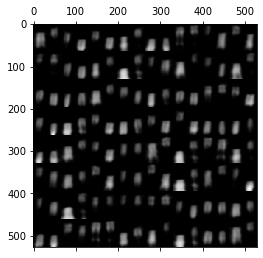

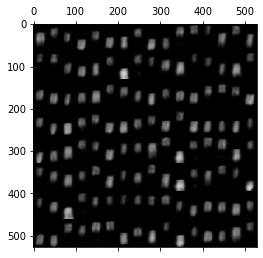

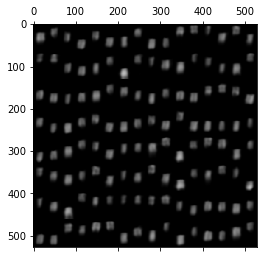

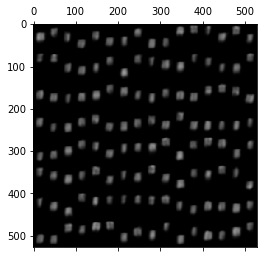

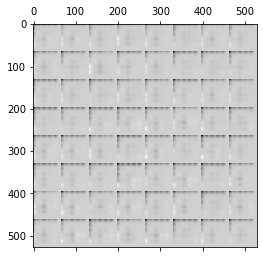

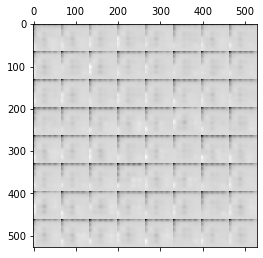

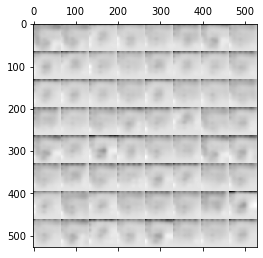

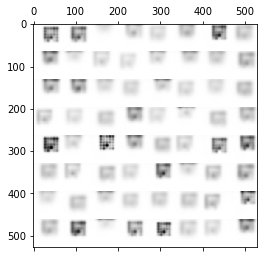

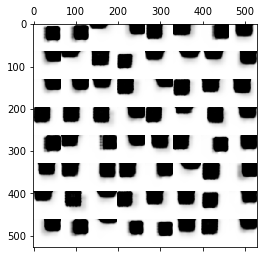

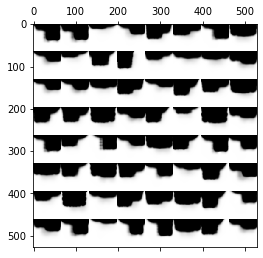

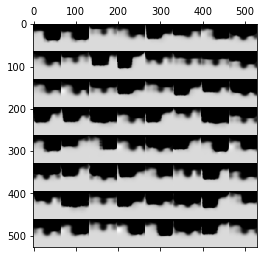

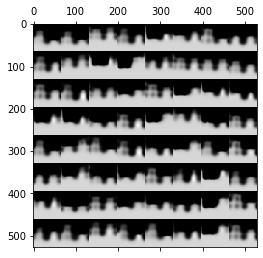

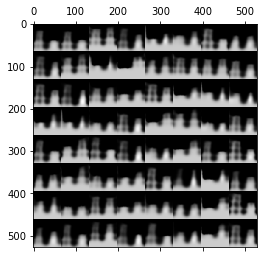

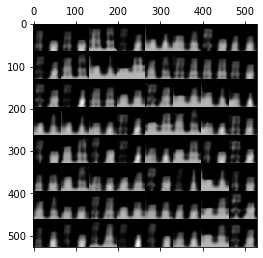

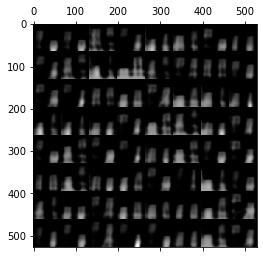

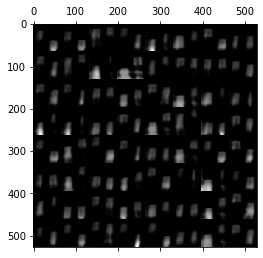

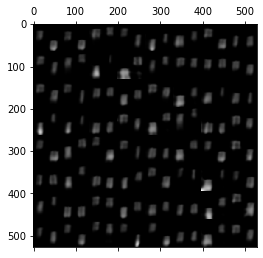

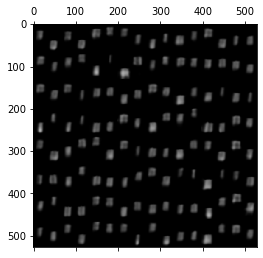

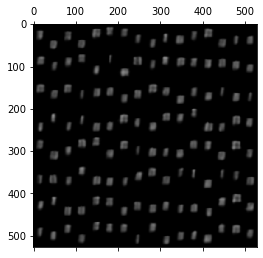

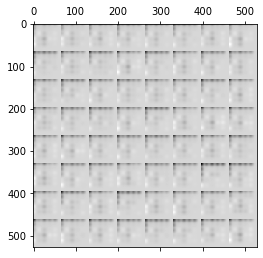

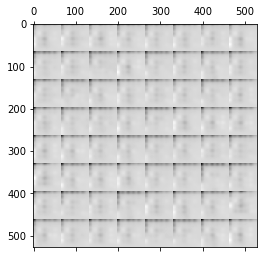

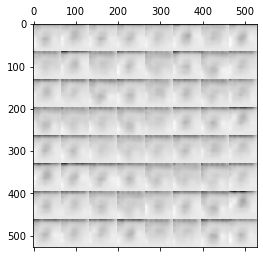

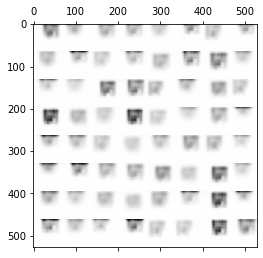

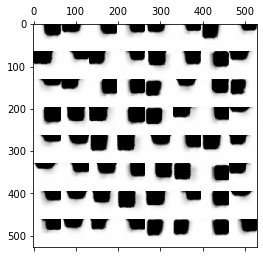

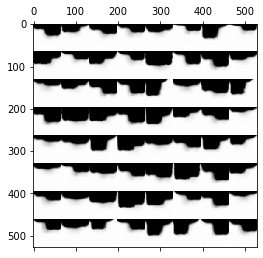

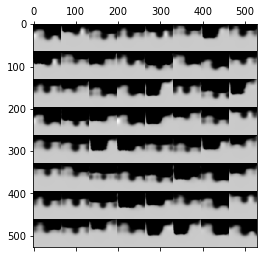

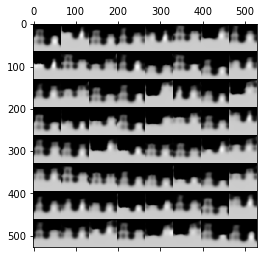

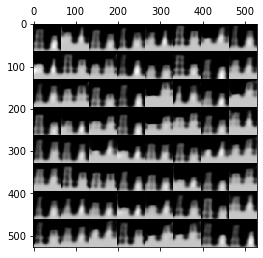

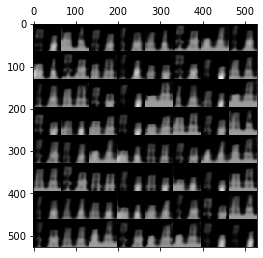

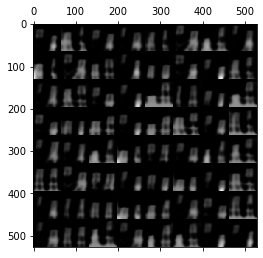

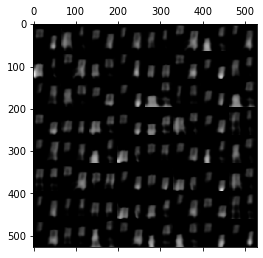

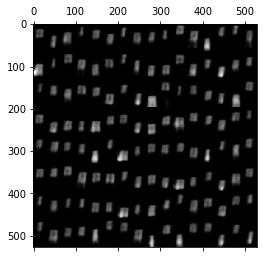

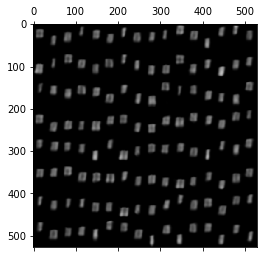

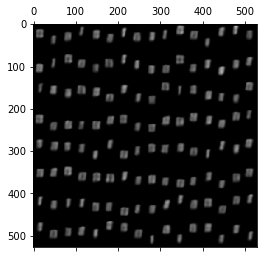

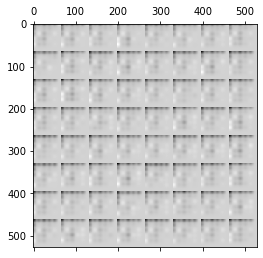

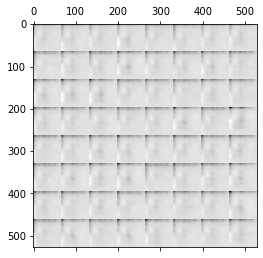

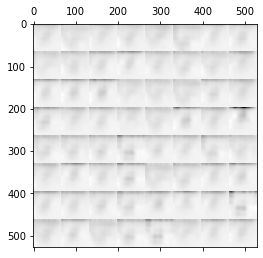

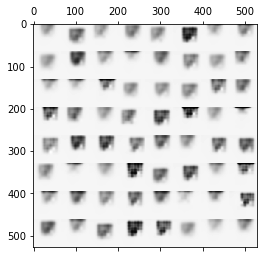

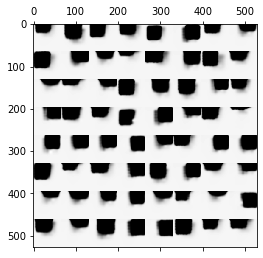

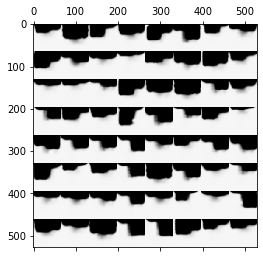

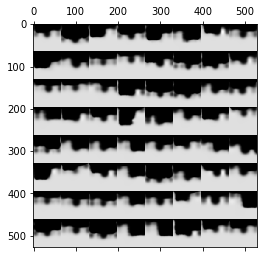

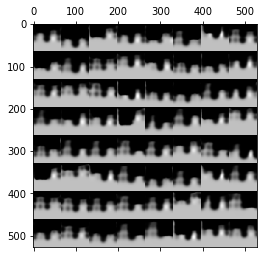

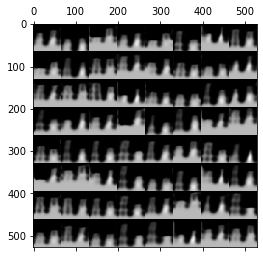

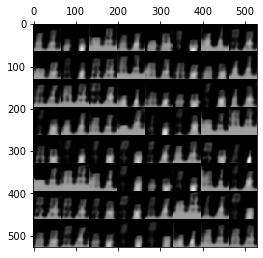

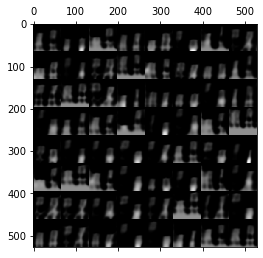

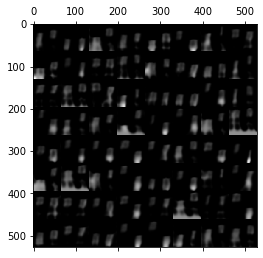

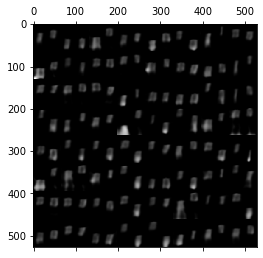

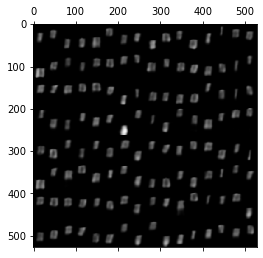

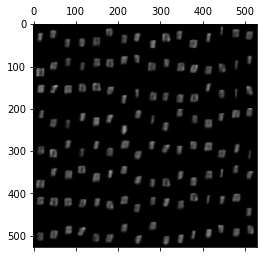

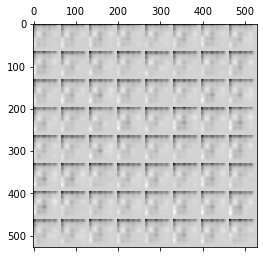

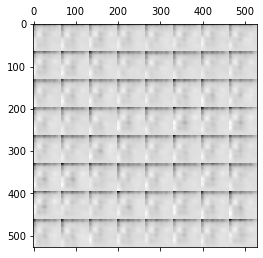

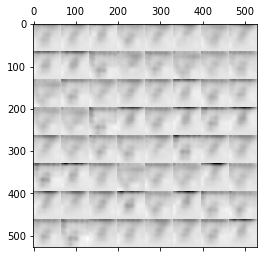

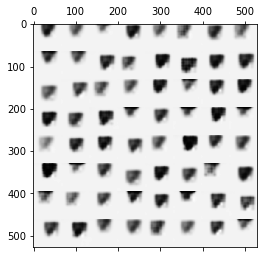

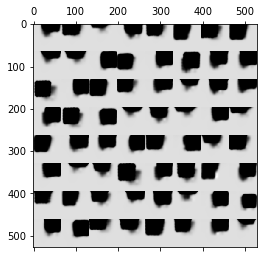

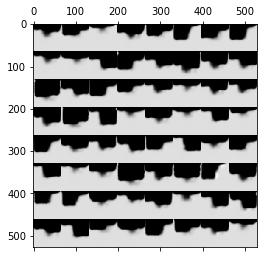

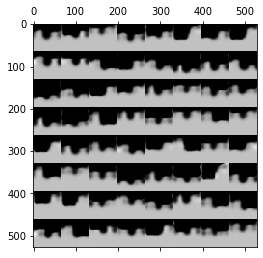

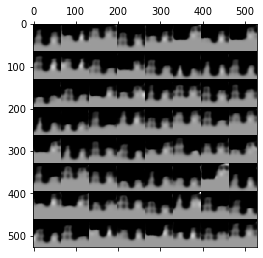

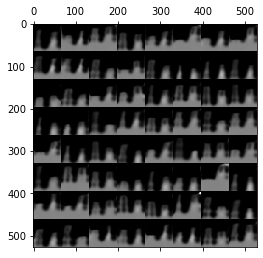

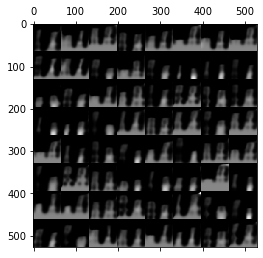

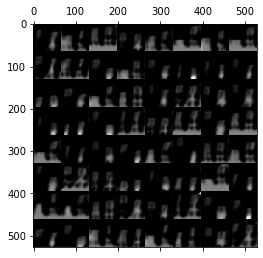

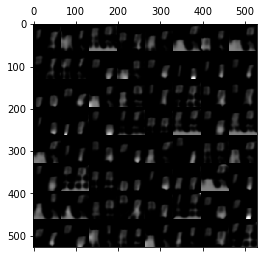

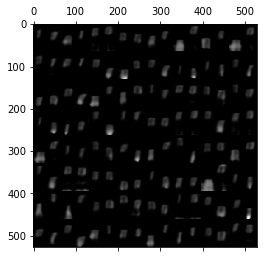

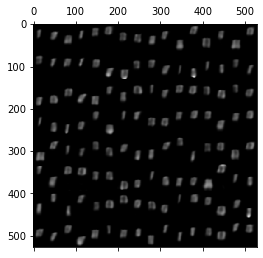

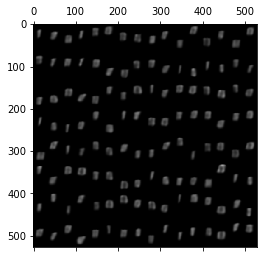

In [45]:
model = DrawModel(T,A,B,z_size,read_size,write_size,dec_size,enc_size,attention)
optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(beta1,0.999))

if USE_CUDA:
    model.cuda()

def train():
    avg_loss = 0
    count = 0
    for epoch in range(epoch_num):
        #change to data,_ for dataset other than multiMNIST
        for data in train_loader:
            bs = data.size()[0]
            data = Variable(data).view(bs, -1)
            optimizer.zero_grad()
            loss = model.loss(data)
            avg_loss += loss.cpu().data.numpy()
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            optimizer.step()
            count += 1
            if count % 100 == 0:
                print ('Epoch-{}; Count-{}; loss: {};'.format(epoch, count, avg_loss / 100))
                if count % 3000 == 0:
                    torch.save(model.state_dict(),'/Users/ivy2021/Documents/DRAW/weights_multi/weights_%d.tar'%(count))
                    generate_image(count)
                avg_loss = 0
    torch.save(model.state_dict(), '/Users/ivy2021/Documents/DRAW/weights_multi/weights_final.tar')
    generate_image(count)


def generate_image(count):
    x = model.generate(batch_size)
    save_image(x,count)

def save_example_image():
    train_iter = iter(train_loader)
    data = train_iter.next()
    img = data.cpu().numpy().reshape(batch_size, 64, 64)
    #print(data)
    #data, _ = train_iter.next()
    #img = data.cpu().numpy().reshape(batch_size, 28, 28)
    imgs = xrecons_grid(img, B, A)
    plt.matshow(imgs, cmap=plt.cm.gray)
    plt.savefig('/Users/ivy2021/Documents/DRAW/gen_image_multi/example.png')

if __name__ == '__main__':
    save_example_image()
    train()

<ipython-input-43-a5d478b16761>:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return autograd.Variable(data,*args, **kwargs)
<ipython-input-43-a5d478b16761>:172: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  ai = torch.ones((delta.size()[0],A)).to('cuda:0') * torch.range(0,A-1).to('cuda:0')
<ipython-input-43-a5d478b16761>:173: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  bj = torch.ones((delta.size()[0],B)).to('cuda:0') * torch.range(0,B-1).to('cuda:0')


/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_0.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_1.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_2.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_3.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_4.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_5.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_6.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_7.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_8.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_9.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_10.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_11.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_12.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_13.png
/Users/ivy2021/Documents/DRAW/gen_image_multi/count_0_test_14.png


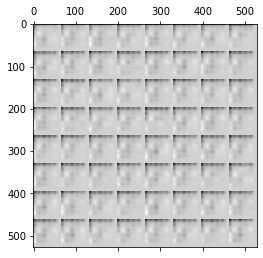

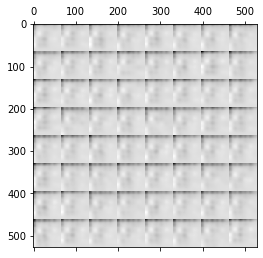

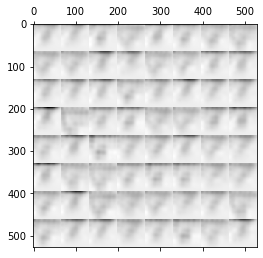

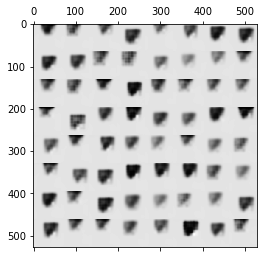

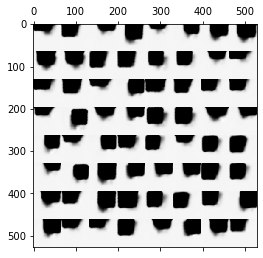

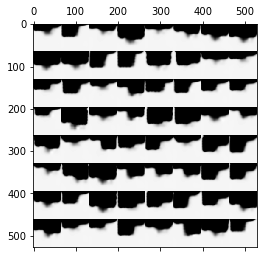

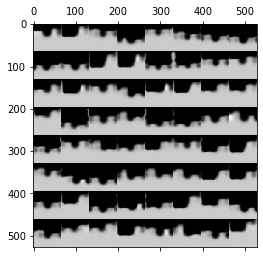

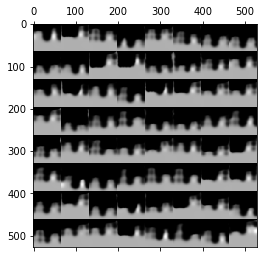

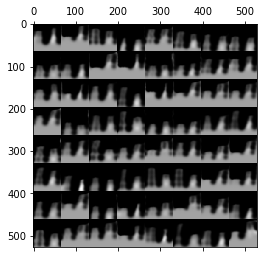

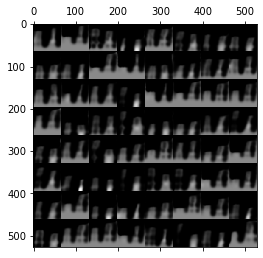

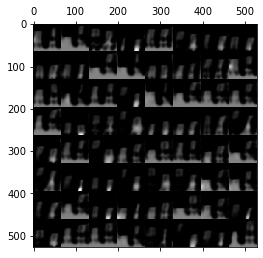

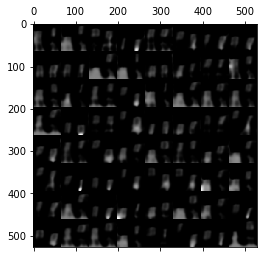

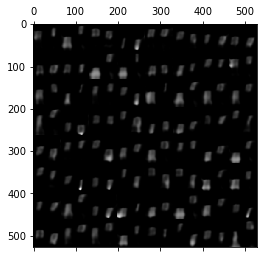

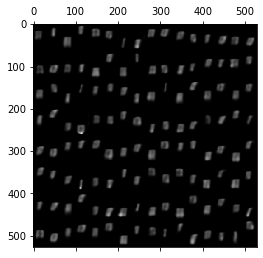

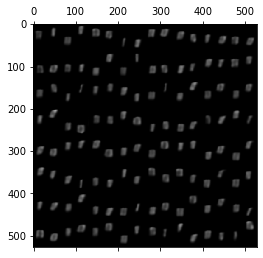

In [47]:
torch.set_default_tensor_type('torch.FloatTensor')

model = DrawModel(T,A,B,z_size,read_size,write_size,dec_size,enc_size, attention)

if USE_CUDA:
    model.cuda()

state_dict = torch.load('/Users/ivy2021/Documents/DRAW/weights_multi/weights_final.tar')
model.load_state_dict(state_dict)
def generate():
    x = model.generate(batch_size)
    save_image(x)

if __name__ == '__main__':
    generate()

(64000, 64, 64)
